In [4]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [5]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot

from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

from tqdm import tqdm, tqdm_notebook
from colorama import Fore
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import time
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import xgboost as xgb
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

# from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

print("All modules have been imported")


All modules have been imported


In [6]:
!apt-get install tree
clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

The syntax of the command is incorrect.


Folder PATH listing for volume New Volume
Volume serial number is D8A5-7653
D:\PRAYAG FILES\TIET\EXTRAS\HACKATHONS\ANALOG\-D
Invalid path - \PRAYAG FILES\TIET\EXTRAS\HACKATHONS\ANALOG\-D
No subfolders exist 



In [7]:
import os
import shutil

IMG_PATH = r"D:\Prayag Files\TIET\Extras\hackathons\analog\Brain_Tumor_Detection"
ignored = {"pred"}

# Define the main folders for train, validation, and test
target_dirs = ["TRAIN", "VAL", "TEST"]

# Loop through each class in the main image folder
for CLASS in os.listdir(IMG_PATH):
    if CLASS not in ignored and not CLASS.startswith('.'):
        # Create subdirectories in each target folder for the class, if they don’t exist
        for target_dir in target_dirs:
            class_dir = os.path.join(target_dir, CLASS.upper())
            os.makedirs(class_dir, exist_ok=True)

        # Get the list of files in each class folder
        class_path = os.path.join(IMG_PATH, CLASS)
        file_list = os.listdir(class_path)
        IMG_NUM = len(file_list)

        for n, FILE_NAME in enumerate(file_list):
            img_path = os.path.join(class_path, FILE_NAME)

            # Copy files to the appropriate split (test, train, val)
            if n < 300:
                shutil.copy(img_path, os.path.join('TEST', CLASS.upper(), FILE_NAME))
            elif n < int(0.8 * IMG_NUM):
                shutil.copy(img_path, os.path.join('TRAIN', CLASS.upper(), FILE_NAME))
            else:
                shutil.copy(img_path, os.path.join('VAL', CLASS.upper(), FILE_NAME))

print("Files have been copied to TRAIN, VAL, and TEST folders.")


Files have been copied to TRAIN, VAL, and TEST folders.


In [8]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [9]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

In [10]:
import os
import numpy as np
import cv2

def load_data(directory, img_size):
    images = []
    labels = []
    class_names = os.listdir(directory)  # Get the names of the subdirectories (classes)
    
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):  # Ensure it is a directory
            for img_file in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_file)
                if img_file.endswith(('.png', '.jpg', '.jpeg')):  # Check for image files
                    img = cv2.imread(img_path)

                    if img is not None:  # Check if the image is read successfully
                        img = cv2.resize(img, img_size)  # Resize to the specified size
                        images.append(img)
                        labels.append(label)  # Use the index as the label
                    else:
                        print(f"Warning: Could not read image {img_path}. Skipping this file.")

    # Convert lists to numpy arrays
    X = np.array(images)
    y = np.array(labels)

    return X, y, class_names

# Example usage
IMG_SIZE = (224, 224)  # Adjust according to your requirements
TRAIN_DIR = 'TRAIN'  # Path to your training data
TEST_DIR = 'TEST'    # Path to your testing data
VAL_DIR = 'VAL'      # Path to your validation data

X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

print("Data loaded:")
print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, Labels shape: {y_test.shape}")
print(f"Validation data shape: {X_val.shape}, Labels shape: {y_val.shape}")


Data loaded:
Training data shape: (1800, 224, 224, 3), Labels shape: (1800,)
Testing data shape: (600, 224, 224, 3), Labels shape: (600,)
Validation data shape: (600, 224, 224, 3), Labels shape: (600,)


In [11]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [12]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

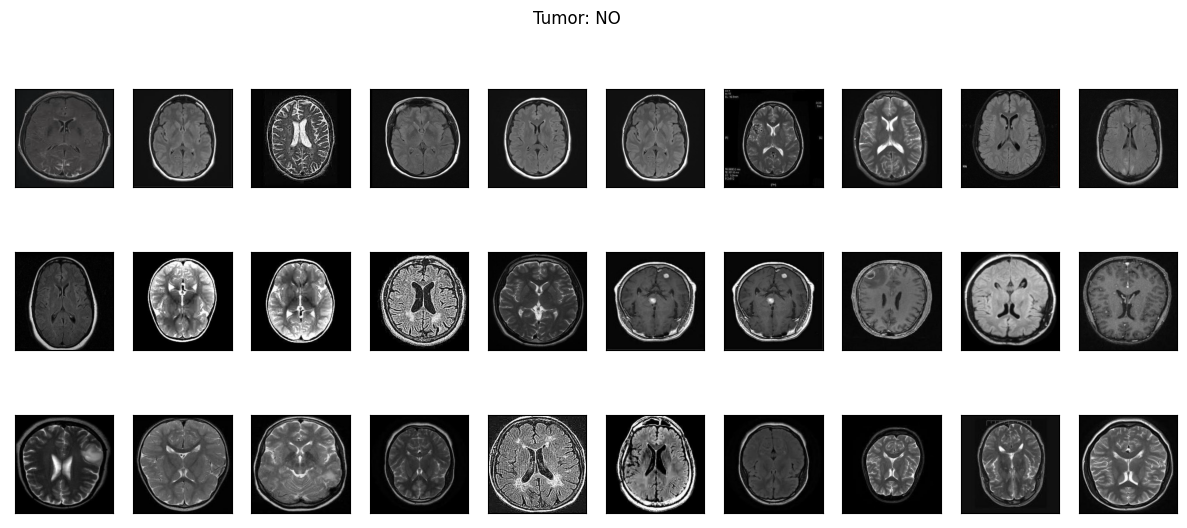

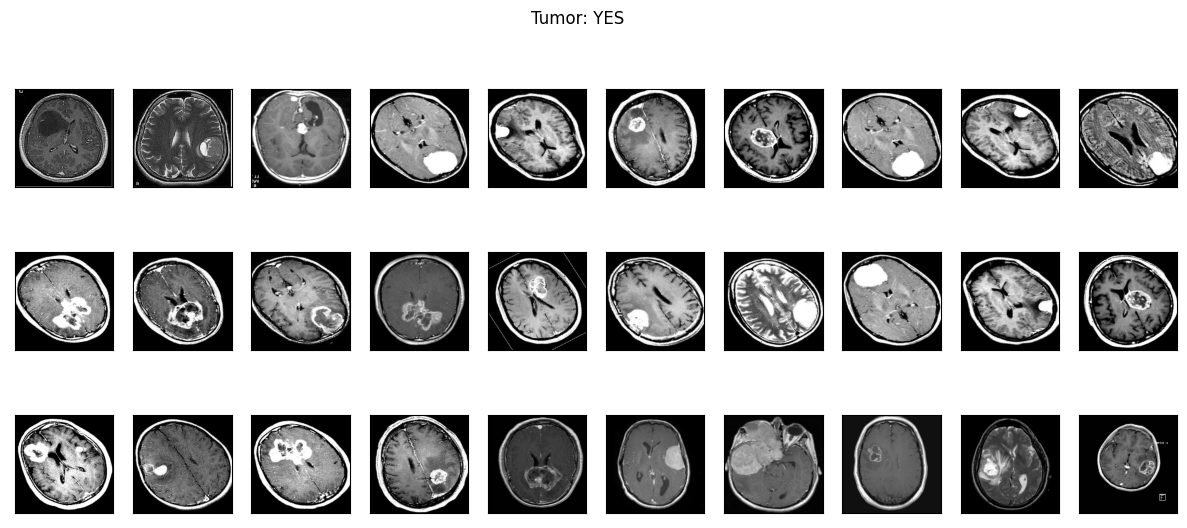

In [13]:
plot_samples(X_train, y_train, labels, 30)

In [14]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [15]:
import imutils
img = cv2.imread('./VAL/NO/no852.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

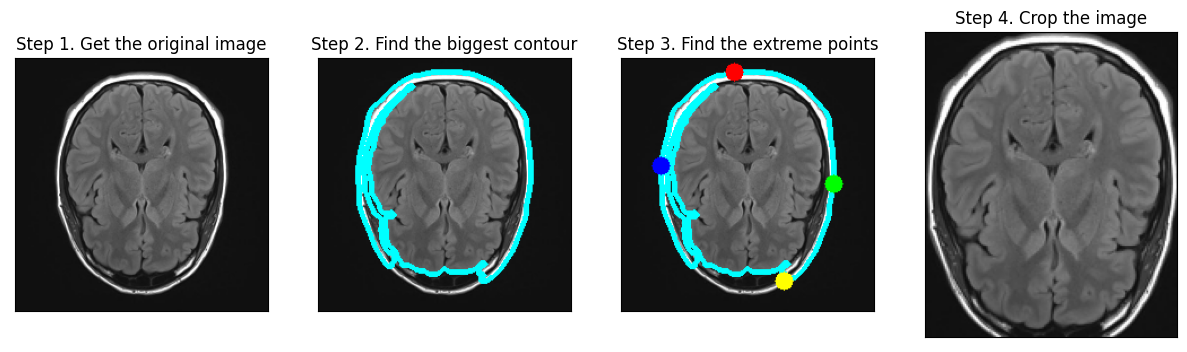

In [16]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [17]:
import cv2
import numpy as np

def crop_imgs(set_name, crop_size=(112, 112)):
    cropped_images = []
    
    for img in set_name:
        if img.ndim == 3:  # Ensure it's a color image
            height, width, _ = img.shape
            
            # Calculate cropping coordinates
            start_x = (width - crop_size[1]) // 2
            start_y = (height - crop_size[0]) // 2
            
            # Ensure cropping coordinates are within bounds
            start_x = max(start_x, 0)
            start_y = max(start_y, 0)
            
            # Crop the image
            cropped_img = img[start_y:start_y + crop_size[0], start_x:start_x + crop_size[1]]
            
            # Check if cropped image has the expected shape
            if cropped_img.shape[0] == crop_size[0] and cropped_img.shape[1] == crop_size[1]:
                cropped_images.append(cropped_img)
            else:
                print(f"Warning: Cropped image has unexpected shape {cropped_img.shape}, skipping.")
        else:
            print("Warning: Image is not in the expected format, skipping.")

    # Convert to NumPy array
    return np.array(cropped_images)

# Example usage
X_train_crop = crop_imgs(X_train)
X_val_crop = crop_imgs(X_val)
X_test_crop = crop_imgs(X_test)

print(f"Cropped training data shape: {X_train_crop.shape}")
print(f"Cropped validation data shape: {X_val_crop.shape}")
print(f"Cropped testing data shape: {X_test_crop.shape}")


Cropped training data shape: (1800, 112, 112, 3)
Cropped validation data shape: (600, 112, 112, 3)
Cropped testing data shape: (600, 112, 112, 3)


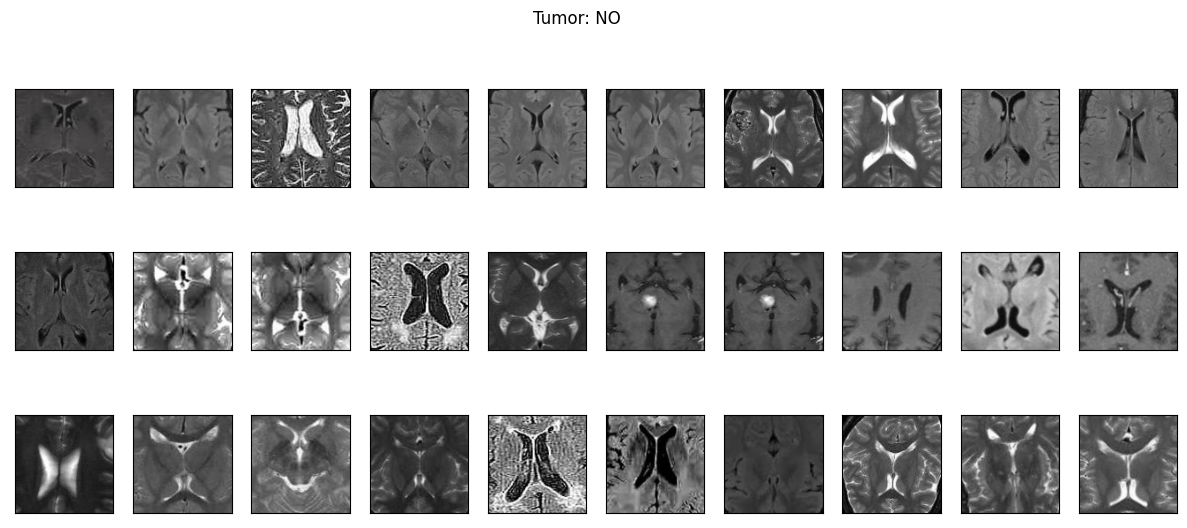

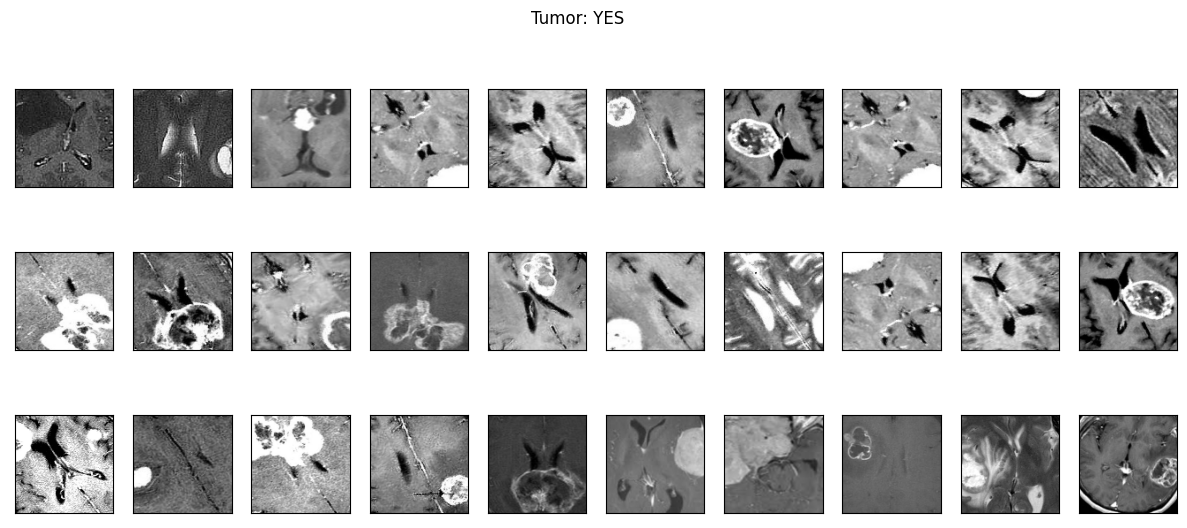

In [18]:
plot_samples(X_train_crop, y_train, labels, 30)

In [19]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [23]:
import os
import cv2

def create_directories():
    # List of directory paths to create
    directories = [
        'TRAIN_CROP/YES',
        'TRAIN_CROP/NO',
        'TEST_CROP/YES',
        'TEST_CROP/NO',
        'VAL_CROP/YES',
        'VAL_CROP/NO'
    ]
    
    for directory in directories:
        os.makedirs(directory, exist_ok=True)

def save_new_images(images, labels, folder_name):
    # Create subfolders for each class using string labels
    for label in np.unique(labels):
        os.makedirs(os.path.join(folder_name, str(label)), exist_ok=True)
    
    for i, img in enumerate(images):
        # Determine the label directory, convert label to string
        label = str(labels[i])
        
        # Construct the filename
        filename = f"{label}_{i}.jpg"  # Custom naming convention
        
        # Save the image
        cv2.imwrite(os.path.join(folder_name, label, filename), img)


# Create directories
create_directories()

# Save cropped images
save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')


In [24]:
def preprocess_imgs(set_name, img_size):
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [25]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

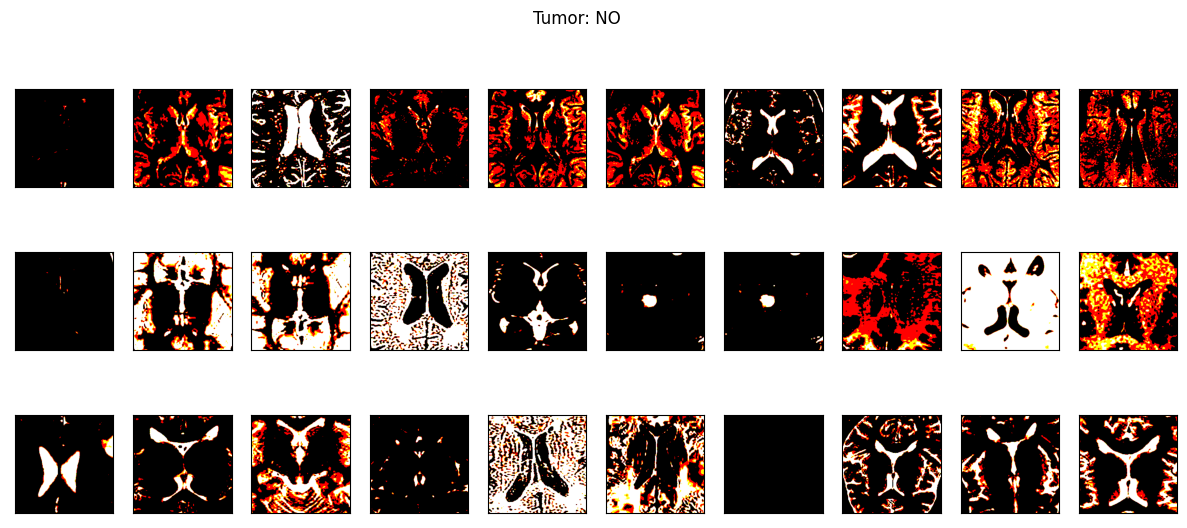

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

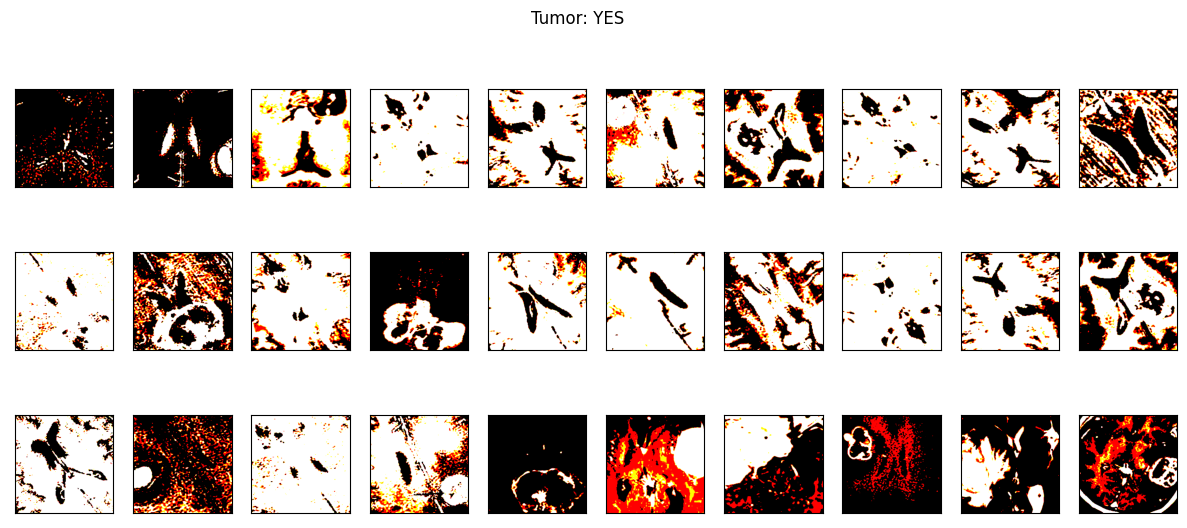

In [26]:
plot_samples(X_train_prep, y_train, labels, 30)

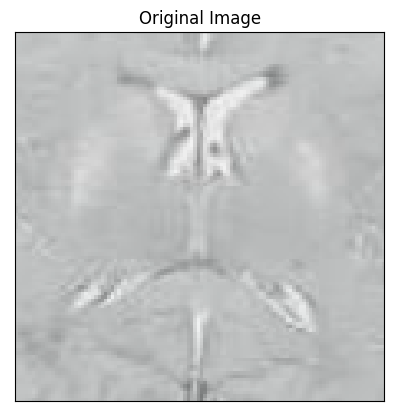

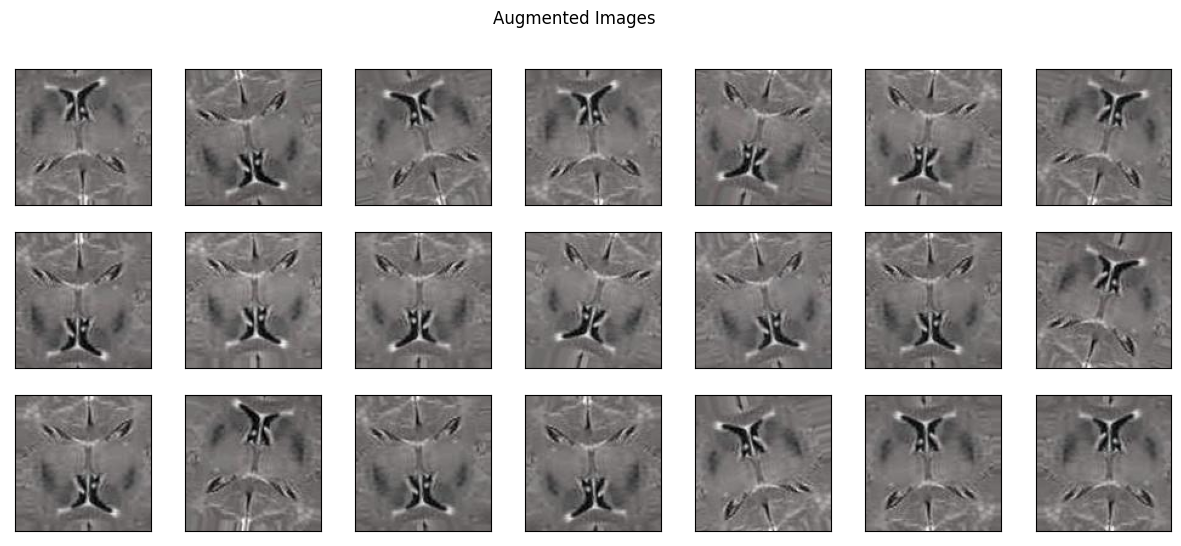

In [29]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a directory for preview images if it doesn't exist
if not os.path.exists('preview'):
    os.mkdir('preview')

# Configure the ImageDataGenerator for augmentation
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

# Take the first image from the cropped training dataset
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

# Generate augmented images
i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

# Display the original image
plt.imshow((X_train_crop[0] * 255).astype(np.uint8))  # Convert to uint8 for display
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

# Display augmented images
plt.figure(figsize=(15, 6))
i = 1
for img_name in os.listdir('preview/'):
    img = cv2.imread(os.path.join('preview', img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 7, i)
    plt.imshow(img)  # Display the image directly
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3 * 7:
        break
plt.suptitle('Augmented Images')
plt.show()


In [30]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'
RANDOM_SEED = 42
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 1800 images belonging to 4 classes.
Found 600 images belonging to 4 classes.


In [31]:
base_Neural_Net= MobileNet(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

for layer in base_Neural_Net.layers:
    layer.trainable = False

    
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy' , 'AUC']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ ?                      │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,228,864 (12.32 MB)

In [33]:
from tensorflow.keras.callbacks import EarlyStopping

EPOCHS = 30

# Define EarlyStopping callback
es = EarlyStopping(
    monitor='val_accuracy',  # Change 'val_acc' to 'val_accuracy'
    mode='max',
    patience=6
)

# Fit the model using the updated method
history = model.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)


Epoch 1/30


c:\Users\Prayag Chawla\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



50/50 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - AUC: 0.7824 - accuracy: 0.7225 - loss: 0.7711 - val_AUC: 0.8911 - val_accuracy: 0.7675 - val_loss: 1.0159
Epoch 2/30
 7/50 ━━━━━━━━━━━━━━━━━━━━ 16s 393ms/step - AUC: 0.9131 - accuracy: 0.8167 - loss: 0.3704

c:\Users\Prayag Chawla\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - AUC: 0.8942 - accuracy: 0.8131 - loss: 0.4174 - val_AUC: 0.9026 - val_accuracy: 0.7950 - val_loss: 0.7252
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 732ms/step - AUC: 0.9203 - accuracy: 0.8472 - loss: 0.3641 - val_AUC: 0.9425 - val_accuracy: 0.8550 - val_loss: 0.3262
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - AUC: 0.9382 - accuracy: 0.8397 - loss: 0.3173 - val_AUC: 0.9489 - val_accuracy: 0.8850 - val_loss: 0.3073
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 763ms/step - AUC: 0.9251 - accuracy: 0.8414 - loss: 0.3487 - val_AUC: 0.9539 - val_accuracy: 0.8750 - val_loss: 0.3381
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - AUC: 0.9283 - accuracy: 0.8640 - loss: 0.3572 - val_AUC: 0.9658 - val_accuracy: 0.8750 - val_loss: 0.3372
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 778ms/step - AUC: 0.9497 - accuracy: 0.8855 - loss: 0.2874 - val_AUC: 0.9681 - val_accuracy: 0.8725 - val_loss: 0.2975
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step

57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 364ms/step
Train Accuracy = 0.94
Confusion matrix, without normalization


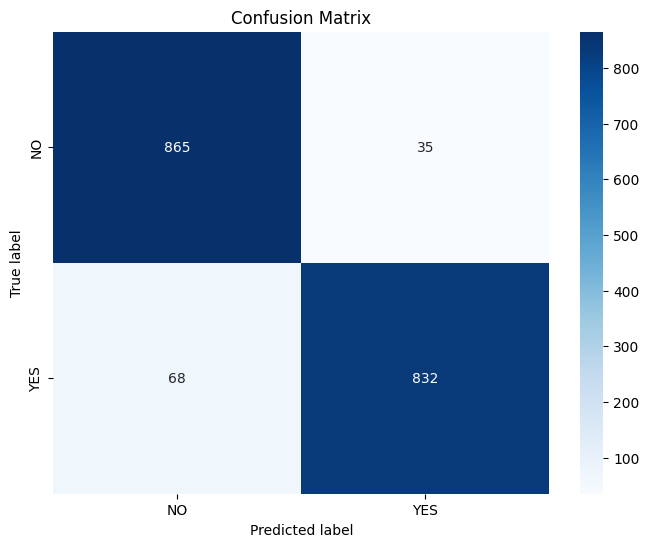

In [35]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

# Assuming model and data (X_train_prep, y_train) are already defined
predictions = model.predict(X_train_prep)
predictions = [1 if x > 0.5 else 0 for x in predictions]

# Calculate accuracy
accuracy = accuracy_score(y_train, predictions)
print('Train Accuracy = %.2f' % accuracy)

# Create confusion matrix
confusion_mtx = confusion_matrix(y_train, predictions)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap=cmap,
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    plt.show()

# Assuming 'labels' is defined appropriately
# If labels is a dictionary, convert it to a list of class names
if isinstance(labels, dict):
    class_names = list(labels.values())
else:
    class_names = labels  # If it's already a list

# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=class_names, normalize=False)


19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 340ms/step
Val Accuracy = 0.92
Confusion matrix, without normalization


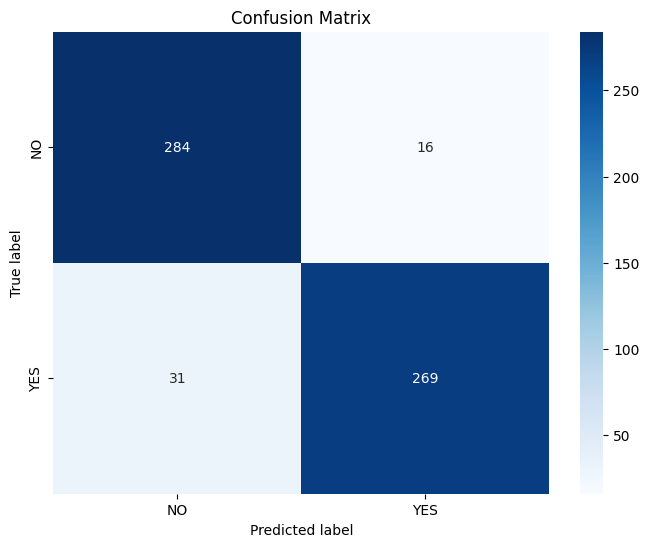

In [37]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

# Assuming model and validation data (X_val_prep, y_val) are already defined
predictions = model.predict(X_val_prep)
predictions = [1 if x > 0.5 else 0 for x in predictions]

# Calculate validation accuracy
accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

# Create confusion matrix
confusion_mtx = confusion_matrix(y_val, predictions)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap=cmap,
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    plt.show()

# Assuming 'labels' is defined appropriately
# If labels is a dictionary, convert it to a list of class names
if isinstance(labels, dict):
    class_names = list(labels.values())
else:
    class_names = labels  # If it's already a list

# Plot the confusion matrix for validation
plot_confusion_matrix(confusion_mtx, classes=class_names, normalize=False)


19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 376ms/step
Test Accuracy = 0.91
Confusion matrix, without normalization


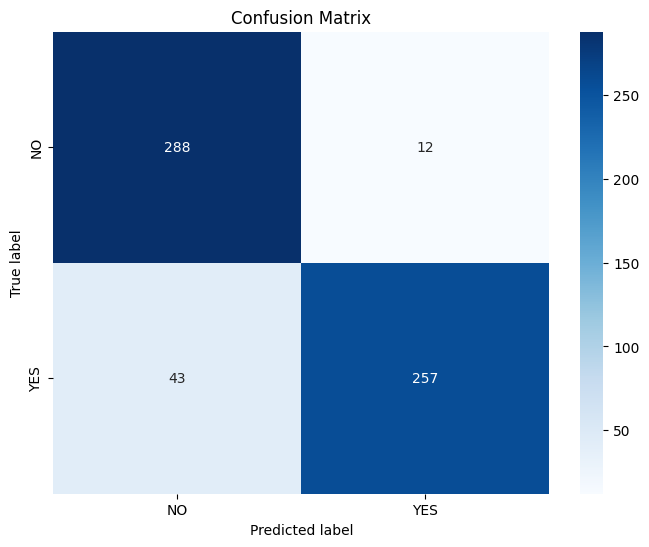

In [38]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

# Assuming model and test data (X_test_prep, y_test) are already defined
predictions = model.predict(X_test_prep)
predictions = [1 if x > 0.5 else 0 for x in predictions]

# Calculate test accuracy
accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

# Create confusion matrix
confusion_mtx = confusion_matrix(y_test, predictions)

# Function to plot confusion matrix (same as before)
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap=cmap,
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    plt.show()

# Assuming 'labels' is defined appropriately
# If labels is a dictionary, convert it to a list of class names
if isinstance(labels, dict):
    class_names = list(labels.values())
else:
    class_names = labels  # If it's already a list

# Plot the confusion matrix for test data
plot_confusion_matrix(confusion_mtx, classes=class_names, normalize=False)


In [44]:
from sklearn import metrics
print('Accuracy score is :', metrics.accuracy_score(y_test, predictions))
print('Precision score is :', metrics.precision_score(y_test, predictions, average='weighted'))
print('Recall score is :', metrics.recall_score(y_test, predictions, average='weighted'))
print('F1 Score is :', metrics.f1_score(y_test, predictions, average='weighted'))


print('\t\tClassification Report:\n', metrics.classification_report(y_test, predictions))

Accuracy score is : 0.9083333333333333
Precision score is : 0.9127404845067891
Recall score is : 0.9083333333333333
F1 Score is : 0.9080879793002988
		Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.91       300
           1       0.96      0.86      0.90       300

    accuracy                           0.91       600
   macro avg       0.91      0.91      0.91       600
weighted avg       0.91      0.91      0.91       600

